## Test land filter, valid waveform filter and ransac filter.

In [1]:
import sys
sys.path.append("../utils")
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
from osgeo import gdal
from tiff_io import readTiff
from imgShow import imgShow
from coor_convert import geo2imagexy
from s3l2_subset import s3l2_subset
from ssha_cal_s3l2 import ssha_cal_s3l2
from ransac_filter import ransac_filter

In [2]:
root_dir = os.path.dirname(os.getcwd())
# path_s3l2 = root_dir+'/test_data/s3a-relative-orbit-260&309/S3A_SR_2_WAT____20190412T021830_20190412T030246_20191218T215941_2656_043_260______MR1_R_NT_004.SEN3/enhanced_measurement_subs_preproc.nc'
path_s3l2 = root_dir+'/test_data/s3a-relative-orbit-260&309/S3A_SR_2_WAT____20190124T133954_20190124T142746_20191218T110840_2872_040_309______MR1_R_NT_004.SEN3/enhanced_measurement_subs_preproc_mainproc.nc'

path_rsimg = root_dir+'/test_data/rs_image/greatbay_l8_img.tif'
path_rsimg_wat = root_dir+'/test_data/rs_image/greatbay_l8_img_wat_sel.tif'


In [3]:
## 1. data reading
img_gdal = gdal.Open(path_rsimg)
l8_img, im_geotrans,im_proj,im_row,im_col,im_bands = readTiff(path_rsimg)
l8_img_wat,_,_,_,_,_ = readTiff(path_rsimg_wat)
s3_l2 = xr.open_dataset(path_s3l2)
# s3_l2


In [4]:
## 2. pre-processing 
#  convert georeference location(lon, lat) to image location (col,row)
lat_fp, lon_fp = s3_l2['lat_20_ku'], s3_l2['lon_20_ku']
col_fps, row_fps = geo2imagexy(lon=s3_l2['lon_20_ku'], lat=s3_l2['lat_20_ku'],img_gdal=img_gdal)


## Land filtering, valid waveform filter and ransac filter

In [5]:
ssha = s3_l2['ssha_estimate_ocean']
## land filter
ssha_land_filter = np.copy(ssha)
ssha_land_filter[s3_l2['surf_type_20_ku'] != 0.0] = np.nan
# ssha_land_filter[s3_l2['fp_wat_per'] != 1] = np.nan
## waveform filter
ssha_land_wf_filter = np.copy(ssha_land_filter)
ssha_land_wf_filter[s3_l2['wf_cls'] != 1] = np.nan
## ransac filter
# ## 1. obtain nearest 40 valid footprint
# dis_valid = np.copy(s3_l2['dis_fp_tgauge'].values)
# dis_valid[np.isnan(ssha_land_wf_filter)] = np.nan
# ind_near_20_valid = np.argpartition(dis_valid, 40)[40:]  # lager distances
# ssha_land_wf_filter[ind_near_20_valid] = np.nan
# 1. obtain near 20 km valid footprint
# ssha_land_wf_filter[s3_l2['dis_fp_tgauge'].values>50] = np.nan
## 2. calculate the ransac
ssha_land_wf_ransac_filter, ssha_land_wf_ransac_pred = ransac_filter(x=s3_l2['lon_20_ku'], y=ssha_land_wf_filter, thre=0.2)


(114.405778, 114.25047199999999, 0.5, 1.2)

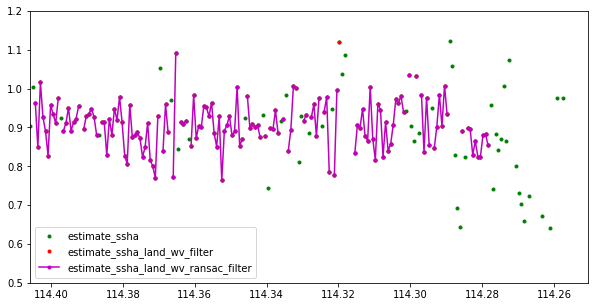

In [6]:
fig = plt.figure(figsize=(10, 5))
plt.plot(s3_l2['lon_20_ku'], ssha, 'g.',label='estimate_ssha')
plt.plot(s3_l2['lon_20_ku'], ssha_land_wf_filter, 'r.',label='estimate_ssha_land_wv_filter')
plt.plot(s3_l2['lon_20_ku'], ssha_land_wf_ransac_filter, 'm.-',label='estimate_ssha_land_wv_ransac_filter')
plt.legend()
plt.axis([s3_l2['lon_20_ku'][0], s3_l2['lon_20_ku'][-100], 0.5, 1.2])


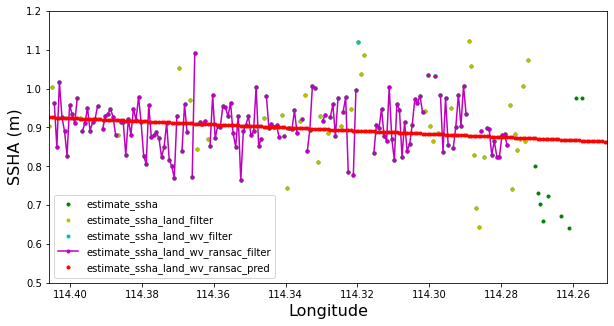

In [7]:
fig = plt.figure(figsize=(10, 5))
plt.plot(s3_l2['lon_20_ku'], ssha, 'g.',label='estimate_ssha')
plt.plot(s3_l2['lon_20_ku'], ssha_land_filter, 'y.',label='estimate_ssha_land_filter')
plt.plot(s3_l2['lon_20_ku'], ssha_land_wf_filter, 'c.',label='estimate_ssha_land_wv_filter')
plt.plot(s3_l2['lon_20_ku'], ssha_land_wf_ransac_filter, 'm.-',label='estimate_ssha_land_wv_ransac_filter')
plt.plot(s3_l2['lon_20_ku'], ssha_land_wf_ransac_pred, 'r.',label='estimate_ssha_land_wv_ransac_pred')
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('SSHA (m)', fontsize=16)
plt.axis([s3_l2['lon_20_ku'][0], s3_l2['lon_20_ku'][-100], 0.5, 1.2])
plt.legend()


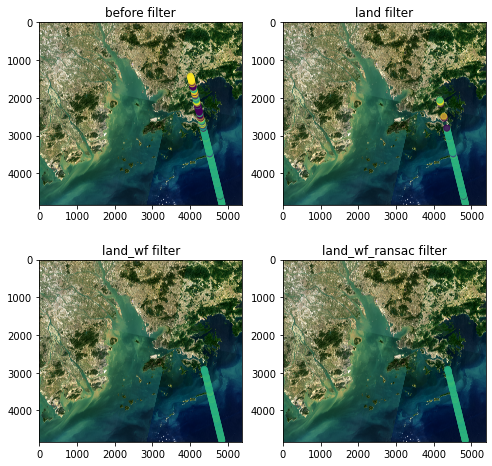

In [8]:
fig = plt.figure(figsize=(8,8))
col_fps, row_fps = geo2imagexy(lon=s3_l2['lon_20_ku'], lat=s3_l2['lat_20_ku'],img_gdal=img_gdal)
ax_1 = plt.subplot(2,2,1)
ax_1.set_title('before filter')
imgShow(l8_img)
plt.scatter(col_fps, row_fps, c=ssha, vmin=-1, vmax=2, alpha=0.5)
ax_2 = plt.subplot(2,2,2)
ax_2.set_title('land filter')
imgShow(l8_img)
plt.scatter(col_fps, row_fps, c=ssha_land_filter, vmin=-1, vmax=2, alpha=0.5)
ax_3 = plt.subplot(2,2,3)
ax_3.set_title('land_wf filter')
imgShow(l8_img)
plt.scatter(col_fps, row_fps, c=ssha_land_wf_filter, vmin=-1, vmax=2, alpha=0.5)
ax_4 = plt.subplot(2,2,4)
ax_4.set_title('land_wf_ransac filter')
imgShow(l8_img)
plt.scatter(col_fps, row_fps, c=ssha_land_wf_ransac_filter, vmin=-1, vmax=2, alpha=0.5)
